In [1]:
import copy
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.utils.data as td
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchmetrics import F1Score, MetricCollection, Precision, Recall
from torchvision.datasets import ImageFolder
from torchvision.models import Inception3
from tqdm import tqdm

warnings.filterwarnings("ignore")

## 1. Объявим [pytorch-lightning](https://www.pytorchlightning.ai/) совместимые классы для батчевой загрузки и обработки данных.

In [2]:
class Subset(td.Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[self.indices[index]]
        return self.transform(image), label

    def __len__(self):
        return len(self.indices)


class DataModule(pl.LightningDataModule):
    def __init__(
            self,
            root: str,
            batch_size: int,
            valid_size: float = 0.2,
            flip_proba: float = 0.5,
            resize=100
    ):
        super().__init__()

        self.root = Path(root)
        self.batch_size = batch_size

        self.base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(resize)
        ])

        self.train_transform = transforms.Compose([
            self.base_transform,
            transforms.RandomHorizontalFlip(p=flip_proba),
            transforms.RandomVerticalFlip(p=flip_proba),
            transforms.RandomRotation(degrees=30, fill=1)
        ])

        train_dataset = ImageFolder(str(self.root / "train"))
        train, valid = self._train_valid_split(train_dataset, valid_size=valid_size)

        self.train = train
        self.valid = valid
        self.test = ImageFolder(str(self.root / "test"), transform=self.base_transform)

    def _train_valid_split(self, dataset, valid_size: float):
        train_indices, valid_indices = train_test_split(
            np.arange(len(dataset)),
            test_size=valid_size,
            stratify=dataset.targets
        )

        train = Subset(dataset, train_indices, transform=self.train_transform)
        valid = Subset(dataset, valid_indices, transform=self.base_transform)

        return train, valid

    def train_dataloader(self):
        return td.DataLoader(self.train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return td.DataLoader(self.valid, batch_size=self.batch_size)

    def test_dataloader(self):
        return td.DataLoader(self.test, batch_size=self.batch_size)

## 2. Напишем свой сверточный классификатор

conv(3x3) => normalize => pool(2x2)

In [3]:
class ConvNormPool(pl.LightningModule):
    def __init__(self, in_channels, out_channels, kernel):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.pool(x)
        x = nn.functional.leaky_relu(x)

        return x


class Model(pl.LightningModule):
    def __init__(self, image_size, num_classes: int, *args, **kwargs):
        super().__init__(*args, **kwargs)

        c, h, w = image_size
        self.num_classes = num_classes

        self.block1 = ConvNormPool(c, 16, kernel=(5, 5))
        self.block2 = ConvNormPool(16, 32, kernel=(5, 5))

        self.fc0 = nn.Linear(32 * 23 * 23, 1000)
        self.bn0 = nn.BatchNorm1d(1000)
        self.fc1 = nn.Linear(1000, num_classes)

    def forward(self, x):
        batch, _, _, _ = x.shape
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(batch, -1)
        x = self.fc0(x)
        x = self.bn0(x)
        x = self.fc1(x)

        return x

## 3. Обертка модели для Pytorch-Lightning

In [4]:
class Classifier(pl.LightningModule):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = model
        num_classes = model.num_classes

        metrics = MetricCollection([
            F1Score(num_classes=num_classes, average="macro"),
            Precision(num_classes=num_classes, average="macro"),
            Recall(num_classes=num_classes, average="macro")
        ])

        self.metrics = nn.ModuleDict({
            "train_metrics": metrics.clone(prefix="train_"),
            "valid_metrics": metrics.clone(prefix="valid_"),
            "test_metrics": metrics.clone(prefix="test_")
        })

    def _step(self, batch, mode):
        x, y = batch
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)

        self.metrics[f"{mode}_metrics"].update(logits, y)

        return loss

    def _compute_metrics(self, mode: str):
        metrics = self.metrics[f"{mode}_metrics"].compute()

        f1 = metrics[f"{mode}_F1Score"].item()
        precision = metrics[f"{mode}_Precision"].item()
        recall = metrics[f"{mode}_Recall"].item()

        self.log(f"{mode}_F1", f1)
        self.log(f"{mode}_Precision", precision)
        self.log(f"{mode}_Recall", recall)

        self.metrics[f"{mode}_metrics"].reset()

        return f1, precision, recall

    def training_step(self, batch, _):
        return self._step(batch, "train")

    def validation_step(self, batch, *args, **kwargs):
        return self._step(batch, "valid")

    def test_step(self, batch, *args, **kwargs):
        return self._step(batch, "test")

    def validation_epoch_end(self, outputs):
        train_f1, train_precision, train_recall = self._compute_metrics("train")
        valid_f1, valid_precision, valid_recall = self._compute_metrics("valid")

        print(f"Train: F1={train_f1:.3f}, Precision={train_precision:.3f}, Recall={train_recall:.3f}")
        print(f"Valid: F1={valid_f1:.3f}, Precision={valid_precision:.3f}, Recall={valid_recall:.3f}")
        print("~" * 30)

    def test_epoch_end(self, ouputs):
        test_f1, test_precision, test_recall = self._compute_metrics("test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

## 4. Инициализация моделей и объекта `pl.Trainer`

In [5]:
datamodule = DataModule(
    root="data",
    batch_size=1024,
    valid_size=0.2
)

model = Model(
    image_size=(3, 100, 100),
    num_classes=131
)

classifier = Classifier(model)

callbacks = [
    pl.callbacks.EarlyStopping(
        monitor="valid_F1",
        patience=2,
        mode="max"
    ),
    pl.callbacks.ModelCheckpoint(
        dirpath="checkpoints",
        monitor="valid_F1",
        mode="max",
        filename="cnn-{epoch}-{valid_F1:.3f}"
    )
]

trainer = pl.Trainer(
    gpus=1,
    max_epochs=3,
    callbacks=callbacks
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [6]:
% % time
trainer.fit(classifier, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Missing logger folder: /src/containers/workspace/gans/01-classification/lightning_logs

  | Name    | Type       | Params
---------------------------------------
0 | model   | Model      | 17.1 M
1 | metrics | ModuleDict | 0     
---------------------------------------
17.1 M    Trainable params
0         Non-trainable params
17.1 M    Total params
68.305    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Train: F1=0.000, Precision=0.000, Recall=0.000
Valid: F1=0.000, Precision=0.000, Recall=0.008
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Train: F1=0.774, Precision=0.783, Recall=0.772
Valid: F1=0.820, Precision=0.871, Recall=0.830
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Validating: 0it [00:00, ?it/s]

Train: F1=0.981, Precision=0.982, Recall=0.981
Valid: F1=0.985, Precision=0.988, Recall=0.985
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Validating: 0it [00:00, ?it/s]

Train: F1=0.994, Precision=0.994, Recall=0.994
Valid: F1=0.990, Precision=0.992, Recall=0.990
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CPU times: user 1h 3min 34s, sys: 2min 22s, total: 1h 5min 57s
Wall time: 6min 25s


## 5. Тестируем нашу модельку

In [7]:
_ = trainer.test(classifier, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_F1': 0.9359943866729736,
 'test_Precision': 0.9539344310760498,
 'test_Recall': 0.9362379312515259}
--------------------------------------------------------------------------------


In [8]:
true, pred = [], []

clf = copy.deepcopy(classifier.model)

clf.cuda()
clf.eval()

for x, y in tqdm(datamodule.test_dataloader()):
    with torch.no_grad():
        logits = clf(x.cuda()).cpu()

    pred.append(logits.argmax(1))
    true.append(y)

true = torch.cat(true).numpy()
pred = torch.cat(pred).numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:16<00:00,  1.41it/s]


## 6. Визуализируем ошибки

In [16]:
def visualize_random_fp(datamodule, true, pred):
    indices = np.where(true != pred)[0]

    _, axs = plt.subplots(5, 4, figsize=(20, 40))

    rnd = np.random.choice(indices, 20, replace=False)

    for i, idx in enumerate(rnd):
        img, label = datamodule.test[idx]
        pred_label = pred[idx]

        classes = datamodule.train.dataset.classes

        axs[i % 5][i % 4].set_title(f"T={classes[label]}, P={classes[pred_label]}")
        axs[i % 5][i % 4].imshow(img.numpy().transpose(1, 2, 0))

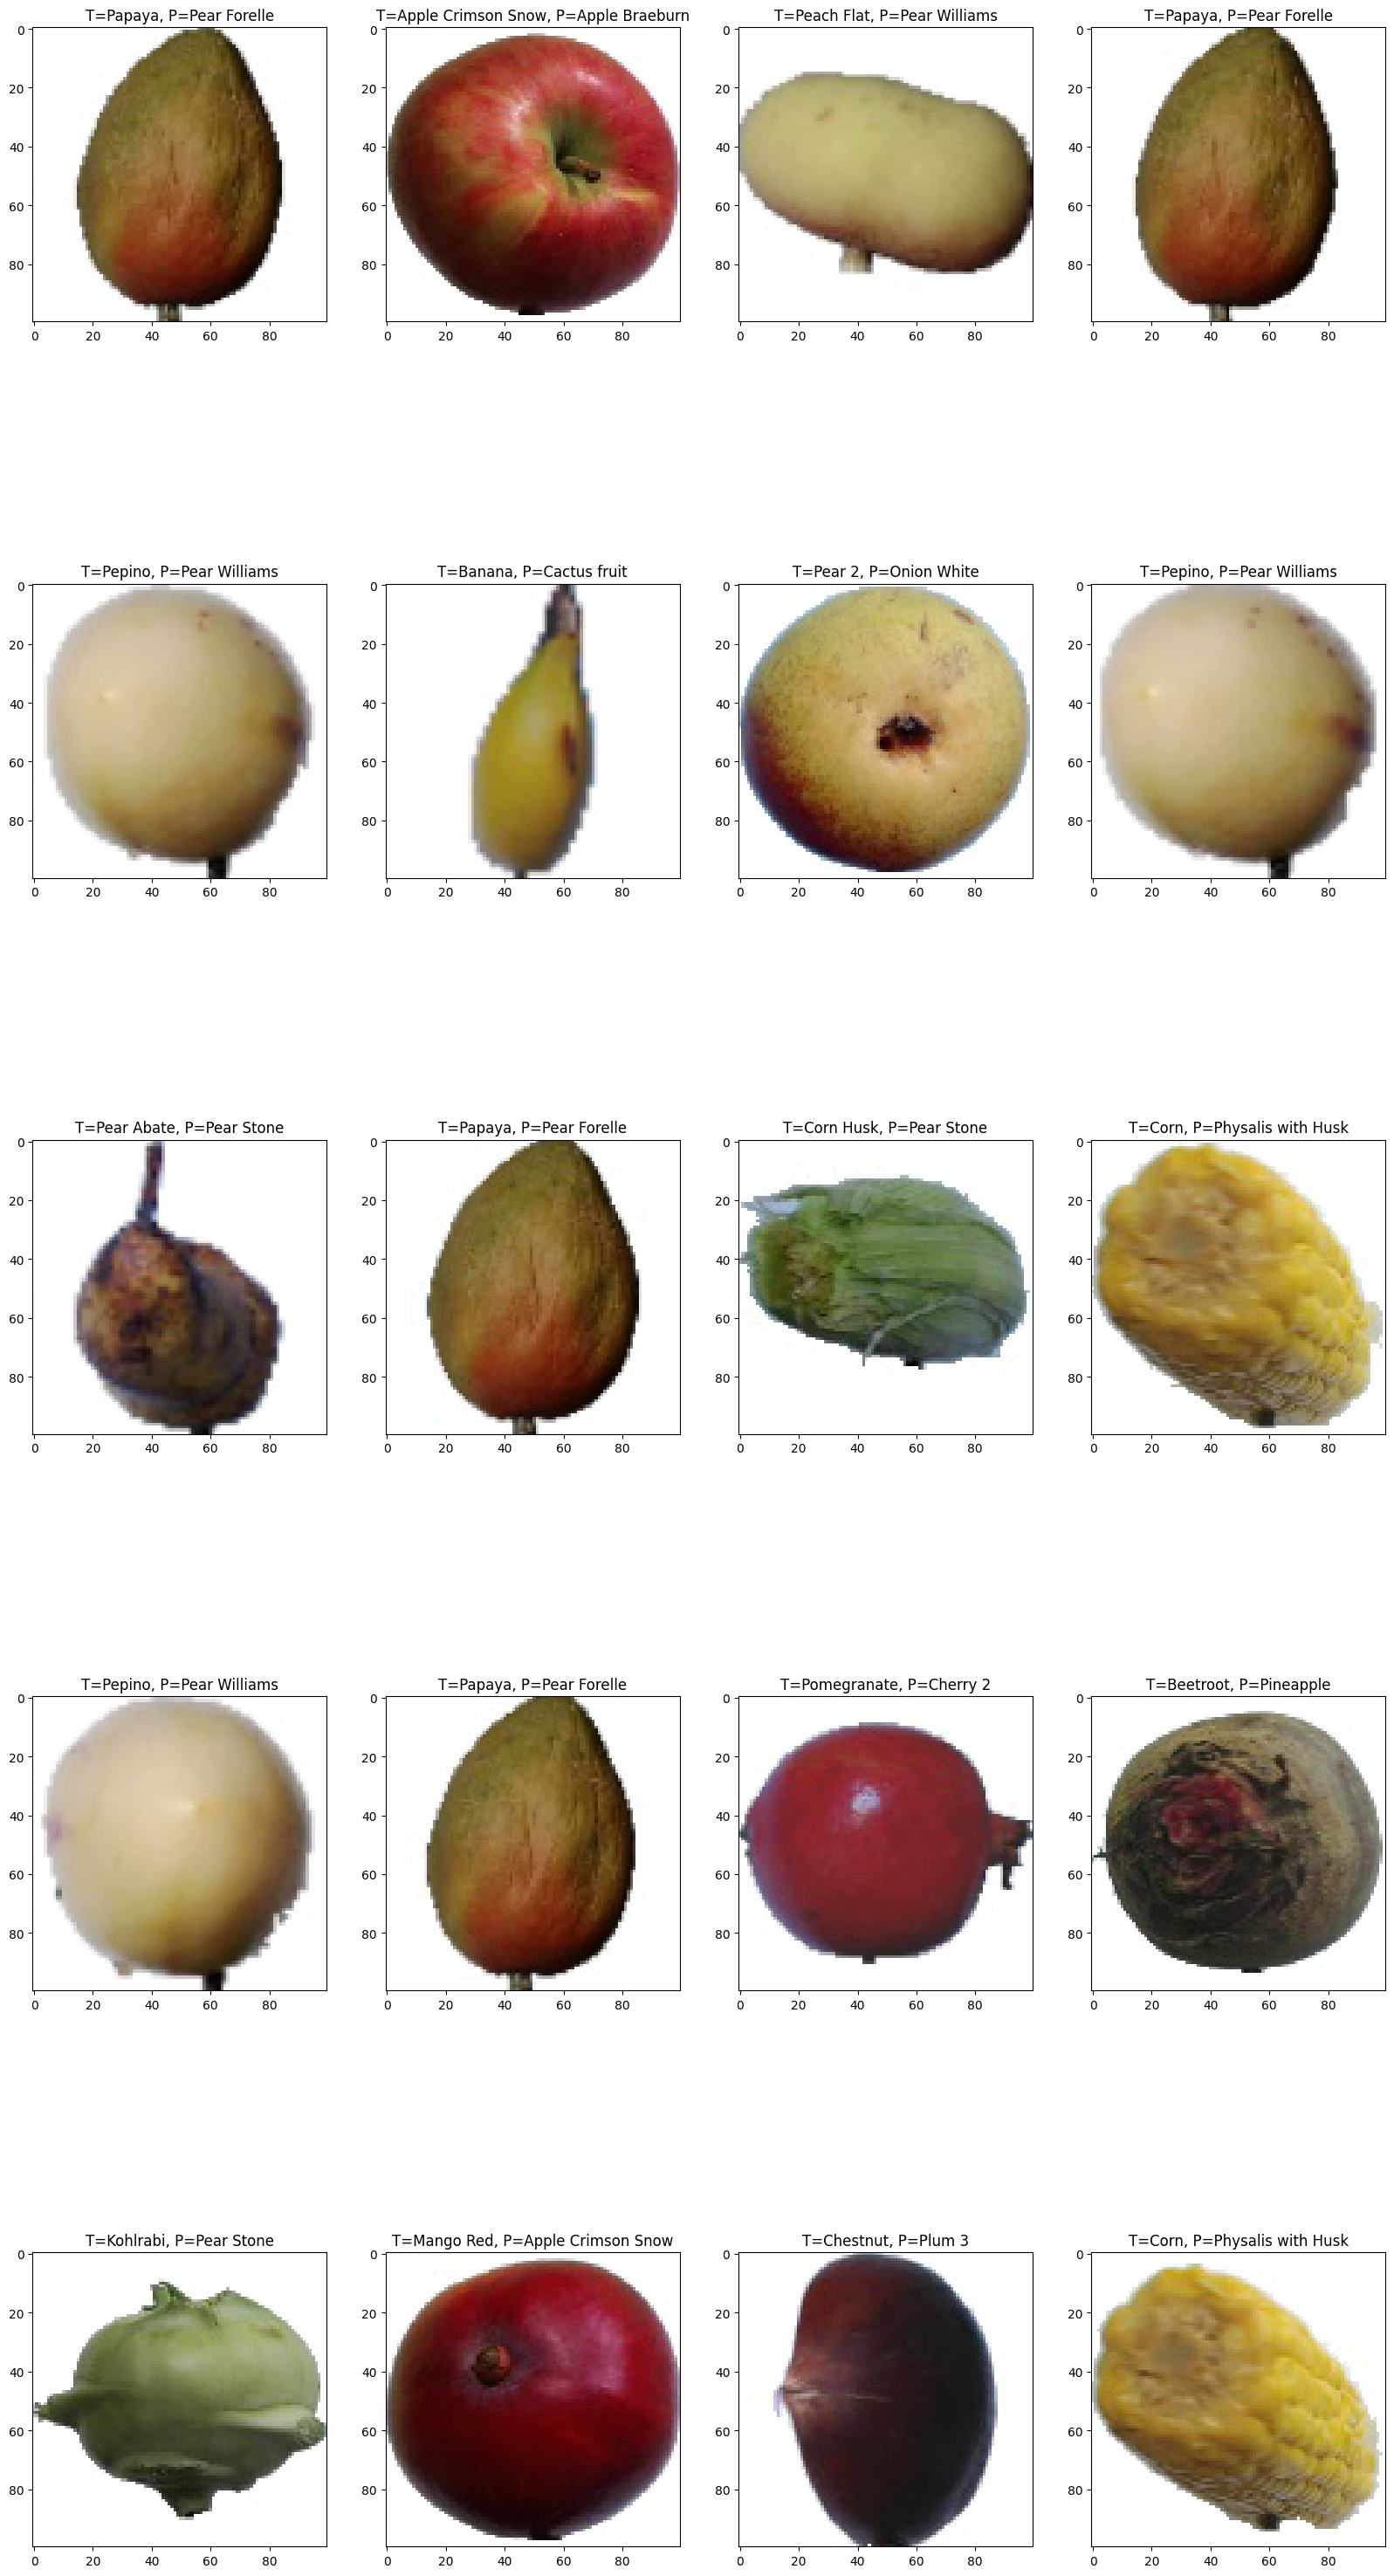

In [10]:
visualize_random_fp(datamodule, true, pred)

## 7. Возьмем предобученную модель Inception

In [11]:
class InceptionModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.num_classes = num_classes
        self.normalize = transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        )

        self.inception = Inception3()
        self.inception.load_state_dict(torch.load("pretrained/inception_v3.pth"))

        self.inception.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.normalize(x)
        x = self.inception(x)

        if self.training:
            return x.logits

        return x

In [12]:
datamodule = DataModule(
    root="data",
    batch_size=64,
    valid_size=0.2,
    resize=299
)

inception = InceptionModel(num_classes=131)
classifier = Classifier(inception)

callbacks = [
    pl.callbacks.EarlyStopping(
        monitor="valid_F1",
        patience=2,
        mode="max"
    ),
    pl.callbacks.ModelCheckpoint(
        dirpath="checkpoints",
        monitor="valid_F1",
        mode="max",
        filename="inception-{epoch}-{valid_F1:.3f}"
    )
]

trainer = pl.Trainer(
    gpus=1,
    max_epochs=3,
    callbacks=callbacks
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
% % time
trainer.fit(classifier, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type           | Params
-------------------------------------------
0 | model   | InceptionModel | 25.4 M
1 | metrics | ModuleDict     | 0     
-------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.523   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Train: F1=0.000, Precision=0.000, Recall=0.000
Valid: F1=0.003, Precision=0.002, Recall=0.011
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Train: F1=0.898, Precision=0.901, Recall=0.896
Valid: F1=0.989, Precision=0.991, Recall=0.989
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Validating: 0it [00:00, ?it/s]

Train: F1=0.980, Precision=0.980, Recall=0.980
Valid: F1=0.988, Precision=0.991, Recall=0.989
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Validating: 0it [00:00, ?it/s]

Train: F1=0.986, Precision=0.986, Recall=0.986
Valid: F1=0.982, Precision=0.985, Recall=0.982
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CPU times: user 5h 40min 52s, sys: 20min 44s, total: 6h 1min 36s
Wall time: 57min 54s


In [14]:
_ = trainer.test(classifier, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_F1': 0.9532893896102905,
 'test_Precision': 0.9645827412605286,
 'test_Recall': 0.9534398317337036}
--------------------------------------------------------------------------------


In [15]:
true, pred = [], []

clf = copy.deepcopy(classifier.model)

clf.cuda()
clf.eval()

for x, y in tqdm(datamodule.test_dataloader()):
    with torch.no_grad():
        logits = clf(x.cuda()).cpu()

    pred.append(logits.argmax(1))
    true.append(y)

true = torch.cat(true).numpy()
pred = torch.cat(pred).numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [02:17<00:00,  2.57it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

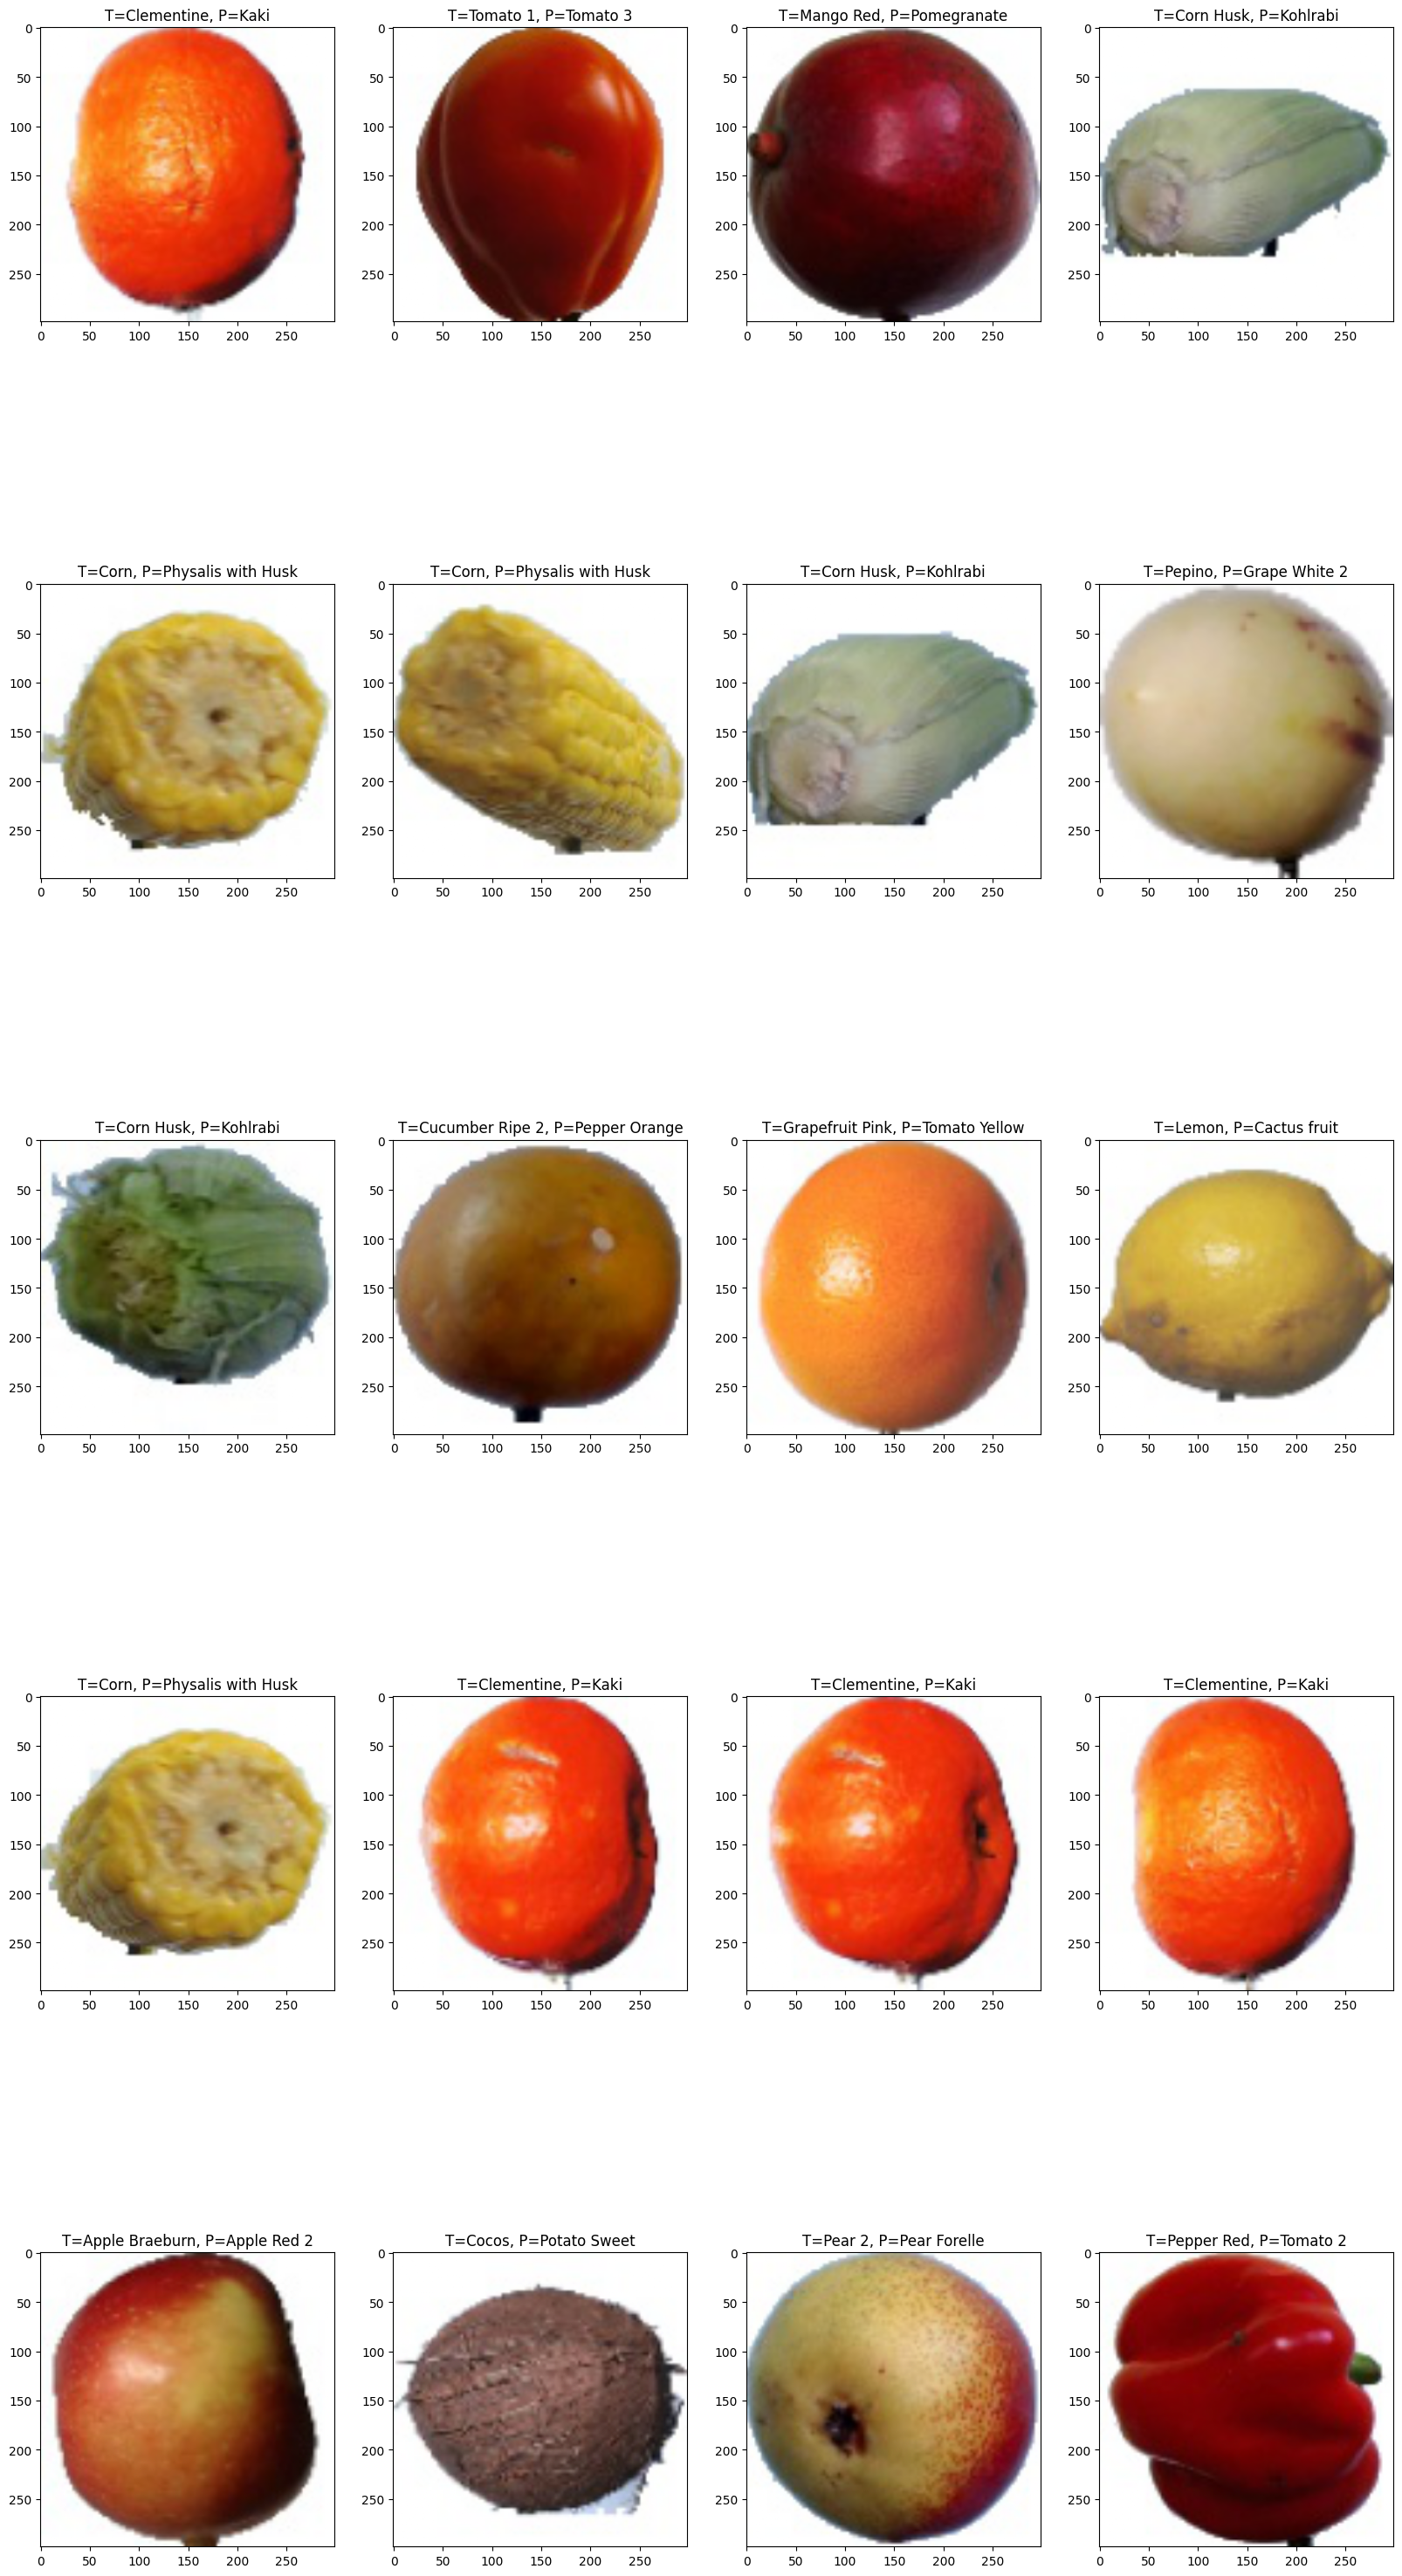

In [17]:
visualize_random_fp(datamodule, true, pred)